# Customer Segmentation Tool 
POC - PRO Xtra Customers in Atlanta Market

## Step 0: Define User Dataset
This dataset will be created under the default project and used as work directory for the analysis. 

In [1]:
import google.datalab.bigquery as bq

# a dataset named 'customer_segmentation' will be created under the default project
output_dataset = 'USER_SXM4690'
bq_output_dataset = bq.Dataset(output_dataset)

# create the dataset if it doesn't exist
if not bq_output_dataset.exists():
  bq_output_dataset.create()

## Step 1: Create Customer List and Pull Seed Data
Step 1.1 populates a customer list from query cs_id and load the list to table cs_id in the selected user dataset. User can also skip Step 1.1, manually create the table and load a list of cs_id to the table.

Step 1.2 will pull seed data for the list of customers in the table and load the seed data to table cs_seed.

### 1.1 Select Customer List (with Query)
In the sample query, we picked customers based in Atlanta.

In [2]:
%%bq query -n cs_id
select a.cust_id
from
(
select
	a.cust_id,
	d.mkt_nbr as top_mkt_nbr,
	d.mkt_nm as top_mkt_nm,
	rank() over(partition by a.cust_id order by sum(coalesce(b.net_sls_amt,0)) desc) as rank
  from
	`pr-customer-thd.EDW_REWARDS.PRO_CUST_SLS_DTL` a,
	unnest(hdr_dtl) b,
	unnest(item_dtl) c,
	unnest(loc_dtl) d,
  `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` e
	  where 1 = 1
          and a.sltrn_dt = e.cal_dt
          and a.cust_id <> 0
          and a.cust_id is not null
          and c.dept_nbr between 21 and 59
          and c.item_class_cd is not null
          and e.fscl_prd_key_val between
            (select fscl_prd_key_val from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
                (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date)))
            and
            (select fscl_prd_key_val from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select prev_fprd_end_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))


  group by 1,2,3
) a
where 1 = 1
and a.rank = 1
and a.top_mkt_nbr = 1

Execute the previous query and save customer list to table cs_id

In [8]:
cs_id_table = output_dataset + '.cs_id'

In [9]:
%%bq execute -q cs_id -t $cs_id_table -m overwrite

cust_id
3299407
4056356
2823234
2853142
1093973
1208354
735760
5216257
2844553
4401922


### 1.2 Pull Seed Data
Seed variables include R12 sales, R12 transactions and Department / Class penetration

In [10]:
%%bq query -n cs_seed
select
    a.cust_id,
    a.s_trd_typ_desc,
    c.dept_nbr,
    c.dept_nm,
    c.item_class_cd,
    c.item_class_desc,
    c.categ_r12_sls_amt,
    d.tot_r12_txn_cnt,
    d.tot_r12_sls_amt
  from
(
    (
    select
        a.cust_id,
        a.s_trd_typ_desc,
        'PAR' as ass_chan
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_DTL` a
          where 1 = 1
          and a.trtry_typ_cd = 1
    ) 
    union all
    (
    select
        a.cust_id,
        a.s_trd_typ_desc,
        'PASA' as ass_chan
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_DTL` a,
        unnest(pasa_dtl) b
          where 1 = 1
          and b.assg_pasa_eff_bgn_ts is not null 
          and b.assg_pasa_eff_end_ts is null 
          and (
            a.trtry_typ_cd in (2,3)
            or
            a.trtry_typ_cd is null
            )
    ) 
    
) a
left join
(
    select
        a.cust_id,
        c.dept_nbr,
        c.dept_nm,
        c.item_class_cd,
        c.item_class_desc,
        sum(coalesce(b.net_sls_amt,0)) as categ_r12_sls_amt
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_SLS_DTL` a,
        unnest(hdr_dtl) b,
        unnest(item_dtl) c,
        `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` d
          where 1 = 1
          and a.sltrn_dt = d.cal_dt
          and a.cust_id <> 0
          and a.cust_id is not null
          and c.dept_nbr  between 21 and 59
          and c.item_class_cd is not null
          and d.cal_dt between
            (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))
            and
            (select prev_fprd_end_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date)
      group by 1,2,3,4,5
) c
on a.cust_id = c.cust_id
left join
(
    select
        a.cust_id,
        count(distinct concat(cast(a.loc_nbr as string),' ',cast(a.sltrn_dt as string),' ',cast(a.pos_rgstr_id as string),' ',cast(a.sltrn_id as string))) as tot_r12_txn_cnt,
        sum(coalesce(b.net_sls_amt,0)) as tot_r12_sls_amt
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_SLS_DTL` a,
        unnest(hdr_dtl) b,
        unnest(item_dtl) c,
        `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` d
          where 1 = 1
          and a.sltrn_dt = d.cal_dt
          and a.cust_id <> 0
          and a.cust_id is not null
          and c.dept_nbr between 21 and 59
          and c.item_class_cd is not null
          and d.cal_dt between
            (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))
            and
            (select prev_fprd_end_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date)
      group by 1
) d
on a.cust_id = d.cust_id
where 1 = 1
and a.cust_id in (select cust_id from USER_SXM4690.cs_id)

## Step 2: Clustering

### 2.0 User Configurations

In [11]:
# user configurations
min_clusters = 2 # a minimum of 2 clusters
max_clusters = 20 # a maximum of 20 clusters
outlier_threshold = 5 # clusters with less than given number of customers will be regarded as outliers

### 2.1 Read Input data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pull seed data into a pandas dataframe
import google.datalab.bigquery as bq
cs_seed_df = cs_seed.execute(output_options=bq.QueryOutput.dataframe()).result()

# Pick customer level variable
cs_seed_var = cs_seed_df.loc[:, ['cust_id', 's_trd_typ_desc', 'tot_r12_txn_cnt', 'tot_r12_sls_amt']].drop_duplicates()
cs_seed_var = cs_seed_var.round({'tot_r12_txn_cnt': 0,'tot_r12_sls_amt': 0})

# Add dept name
cs_seed_dept = cs_seed_df.assign(dept = 'D' + cs_seed_df.dept_nbr.astype(str) + '_' + cs_seed_df.dept_nm,
                               dept_r12_sls_pcnt=cs_seed_df.categ_r12_sls_amt / cs_seed_df.tot_r12_sls_amt)

# Calculate department penetration
cs_seed_dept = cs_seed_dept.groupby(['cust_id', 'dept']).agg({'dept_r12_sls_pcnt': 'sum'}).reset_index()
cs_seed_dept = cs_seed_dept.round({'dept_r12_sls_pcnt': 3})

# Reshape department penetration into wide format so each department is a separate column
cs_seed_dept = cs_seed_dept.pivot(index='cust_id', columns='dept', values='dept_r12_sls_pcnt').reset_index()
cs_seed_dept = cs_seed_dept.fillna(0)

# Join customer level variables with dept penetration
cs_seed_var = cs_seed_var.merge(cs_seed_dept, on='cust_id')

### 2.2 Clustering

#### 2.2.1 Data Normalization

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# select seed variables and standardize
input_df = cs_seed_var.iloc[:,2:14]
input_df_scaled = StandardScaler().fit_transform(input_df)
input_df_scaled = pd.DataFrame(input_df_scaled)

#### 2.2.2 Sihouette Analysis
Sihouette analysis is used to find optimal number of clusters. 

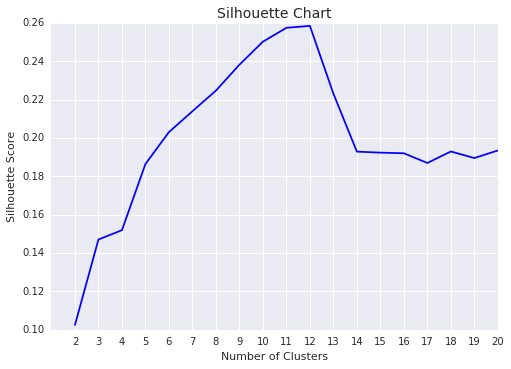

Silhouette analysis recommends 12 clusters.


In [16]:
# silhouette analysis
range_n_clusters = range(min_clusters, max_clusters+1)

def cal_cluster_silhouette(dataset, clusters):
    clusterer = KMeans(n_clusters=clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dataset)
    silhouette_avg = silhouette_score(dataset, cluster_labels)
    return (clusters, silhouette_avg)

avg_silhouette = [] # create a list for number of clusters and average silhouette value

for i in range_n_clusters:
    avg_silhouette.append(cal_cluster_silhouette(input_df_scaled, i))

silhouette_chart = pd.DataFrame(avg_silhouette)

silhouette_chart.rename(columns=dict(zip(silhouette_chart.columns, ['number_of_clusters', 'silhouette_score'])), inplace=True)

fig, ax = plt.subplots()

ax.plot(silhouette_chart['number_of_clusters'], silhouette_chart['silhouette_score'], 'b-')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

plt.title('Silhouette Chart', fontsize=14)

plt.gca().set_xlim(left=1)
plt.xticks(np.arange(min_clusters, max_clusters+1, 1.0) )

plt.show()

# find recommended number of clusters
from operator import itemgetter
recommended_clusters = max(avg_silhouette,key=itemgetter(1))[0] # recommend num of clusters with highest silhouette

print('Silhouette analysis recommends ' + str(recommended_clusters) + ' clusters.')

#### 2.2.3 Clustering

In [17]:
# kmeans clustering
clusterer = KMeans(n_clusters=recommended_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(input_df_scaled)
cs_seed_var['cluster'] = cluster_labels + 1

# adjust cluster # by number of customers
# reorder cluster number based on R12 sales
cluster_size = cs_seed_var.groupby('cluster').agg({'cust_id': 'count'}).reset_index()
cluster_size['cluster_new'] = cluster_size['cluster']
cluster_size['cluster_new'] = cluster_size['cust_id'].rank(ascending=False, method='first')

# update new cluster index
cs_cluster = cs_seed_var.merge(cluster_size[['cluster', 'cluster_new']], on='cluster')
cs_cluster = cs_cluster.drop(['cluster'], axis=1).rename(columns = {'cluster_new': 'cluster'})

## Step 3: Cluster Summary

### 3.1 Subtrade Distribution

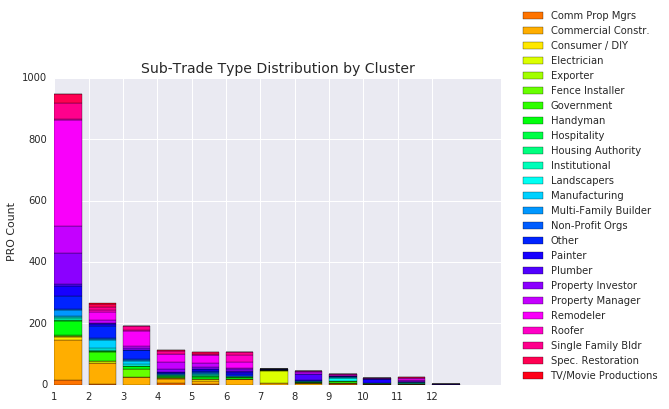

,cluster #,total customers count
0,1.0,968
1,2.0,273
2,3.0,206
3,4.0,117
4,5.0,112
5,6.0,109
6,7.0,52
7,8.0,46
8,9.0,36
9,10.0,25


In [18]:
subtrade = cs_cluster.groupby(['cluster', 's_trd_typ_desc'], as_index=False).agg({'cust_id': 'count'}).reset_index()
subtrade_pivot = subtrade.pivot(index='cluster', columns='s_trd_typ_desc', values='cust_id').reset_index()
subtrade_pivot = subtrade_pivot.fillna(0)

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(len(subtrade_pivot.columns))

# cumulative count
cumu = np.repeat(0, max(subtrade_pivot['cluster']))

for i in range(2,len(subtrade_pivot.columns)):
  d = plt.bar(subtrade_pivot['cluster'], subtrade_pivot.iloc[:,i], bottom=cumu, width=0.8, color=cmap(i), label=subtrade_pivot.columns.values[i])
  cumu = subtrade_pivot.iloc[:,i] + cumu

plt.ylabel('PRO Count')
plt.title('Sub-Trade Type Distribution by Cluster', fontsize=14)

plt.gca().set_xlim(left=1)
plt.xticks(np.arange(min(subtrade_pivot['cluster']), max(subtrade_pivot['cluster'])+1, 1.0) )

plt.legend(loc=(1.04,0))

plt.show()

# print cluster size
cluster_size[['cluster_new', 'cust_id']].sort_values('cluster_new').rename(columns={'cluster_new': 'cluster #', 'cust_id': 'total customers count'}).reset_index(drop=True)

### 3.2 Seed Variables Distribution

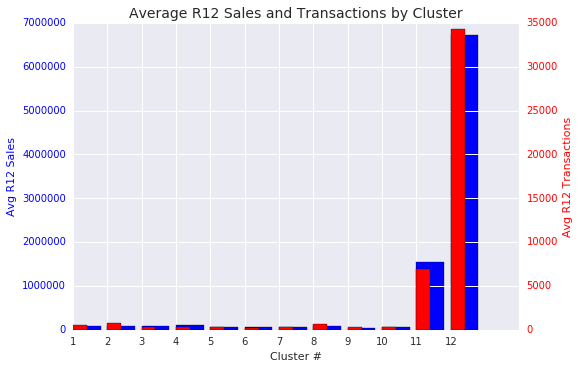

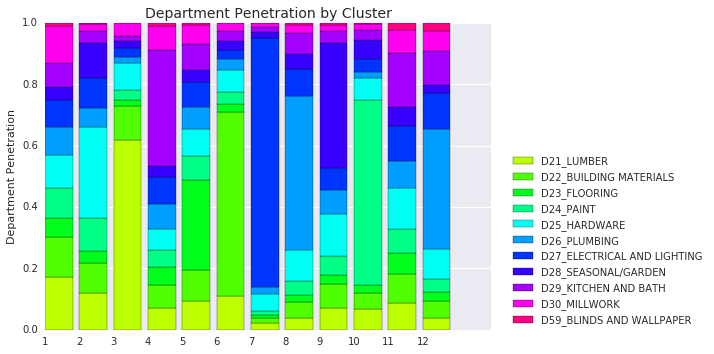

,cluster #,Total R12 Transactions,Total R12 Sales,D21_LUMBER,D22_BUILDING MATERIALS,D23_FLOORING,D24_PAINT,D25_HARDWARE,D26_PLUMBING,D27_ELECTRICAL AND LIGHTING,D28_SEASONAL/GARDEN,D29_KITCHEN AND BATH,D30_MILLWORK,D59_BLINDS AND WALLPAPER
0,1.0,555.0,90449.0,0.172,0.128,0.065,0.095,0.107,0.091,0.089,0.044,0.078,0.120,0.010
1,2.0,722.0,86856.0,0.121,0.097,0.040,0.107,0.297,0.060,0.099,0.113,0.041,0.021,0.004
2,3.0,275.0,80589.0,0.620,0.109,0.019,0.034,0.088,0.019,0.028,0.025,0.016,0.041,0.001
3,4.0,369.0,115606.0,0.070,0.075,0.062,0.055,0.066,0.082,0.089,0.036,0.378,0.078,0.010
4,5.0,317.0,67128.0,0.092,0.101,0.294,0.079,0.087,0.072,0.081,0.039,0.085,0.062,0.007
5,6.0,247.0,68820.0,0.110,0.599,0.028,0.040,0.071,0.035,0.032,0.027,0.035,0.024,0.001
6,7.0,322.0,72245.0,0.021,0.016,0.013,0.010,0.058,0.020,0.813,0.019,0.016,0.014,0.001
7,8.0,697.0,77100.0,0.040,0.051,0.023,0.045,0.101,0.503,0.085,0.052,0.067,0.027,0.006
8,9.0,326.0,44411.0,0.072,0.076,0.030,0.064,0.134,0.079,0.071,0.407,0.042,0.017,0.007
9,10.0,327.0,58673.0,0.069,0.051,0.028,0.602,0.072,0.019,0.043,0.061,0.034,0.017,0.005


In [19]:
# calculate the average of seed variable value for each cluster
seed_avg = cs_cluster.iloc[:,2:17].groupby('cluster').mean().reset_index()

# plot R12 metrics
fig, ax1 = plt.subplots()

ax1.bar(seed_avg['cluster'], seed_avg['tot_r12_sls_amt'], color='b', label='Avg R12 Sales')
ax1.set_xlabel('Cluster #')
ax1.set_ylabel('Avg R12 Sales', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.bar(seed_avg['cluster'], seed_avg['tot_r12_txn_cnt'], color='r', width=0.4)
ax2.set_ylabel('Avg R12 Transactions', color='r')
ax2.tick_params('y', colors='r')

plt.title('Average R12 Sales and Transactions by Cluster', fontsize=14)
plt.gca().set_xlim(left=1)
plt.xticks(np.arange(min(seed_avg['cluster']), max(seed_avg['cluster'])+1, 1.0))

plt.show()

# plot dept penetration
cmap = get_cmap(15)

# cumulative spending penetration
cumu = np.repeat(0, max(seed_avg['cluster']))

for i in range(3,14):
  d = plt.bar(seed_avg['cluster'], seed_avg.iloc[:,i], bottom=cumu, width=0.8, color=cmap(i), label=seed_avg.columns.values[i])
  cumu = seed_avg.iloc[:,i] + cumu

plt.ylabel('Department Penetration')
plt.title('Department Penetration by Cluster', fontsize=14)

plt.gca().set_xlim(left=1)
plt.xticks(np.arange(min(seed_avg['cluster']), max(seed_avg['cluster'])+1, 1.0) )

plt.gca().set_ylim([0,1])

plt.legend(loc=(1.04,0))

plt.show()


# display data
seed_avg = seed_avg.round(3)
seed_avg = seed_avg.round({'tot_r12_txn_cnt': 0,'tot_r12_sls_amt': 0})

seed_avg.rename(columns={'cluster': 'cluster #', 'tot_r12_txn_cnt': 'Total R12 Transactions', 'tot_r12_sls_amt': 'Total R12 Sales'}).reset_index(drop=True)

### 3.3 Review Outliers

Clusters which size is less than outlier threshold will be displayed here:

In [20]:
cluster_size[['cluster_new', 'cust_id']][cluster_size['cust_id'] < outlier_threshold].rename(columns={'cluster_new': 'cluster #', 'cust_id': 'total customers count'})

,cluster #,total customers count
7,12.0,2


The following customers are outliers:

In [21]:
outlier = cs_cluster[cs_cluster['cluster'] >= min(cluster_size['cluster_new'][cluster_size['cust_id'] < outlier_threshold])]
outlier.rename(columns={'cluster': 'cluster #', 's_trd_typ_desc': 'Subtrade Type', 'tot_r12_txn_cnt': 'Total R12 Transactions', 'tot_r12_sls_amt': 'Total R12 Sales'})

,cust_id,Subtrade Type,Total R12 Transactions,Total R12 Sales,D21_LUMBER,D22_BUILDING MATERIALS,D23_FLOORING,D24_PAINT,D25_HARDWARE,D26_PLUMBING,D27_ELECTRICAL AND LIGHTING,D28_SEASONAL/GARDEN,D29_KITCHEN AND BATH,D30_MILLWORK,D59_BLINDS AND WALLPAPER,cluster #
1968,1536773,Property Investor,30032,9034337.0,0.050,0.055,0.052,0.056,0.110,0.152,0.163,0.015,0.169,0.127,0.051,12.0
1969,1478250,Plumber,38523,4425515.0,0.027,0.056,0.005,0.032,0.085,0.626,0.077,0.037,0.052,0.003,0.000,12.0


In [ ]:
print('Please review clustering result before running granular clustering. ')
break

## Step 4: Granular Clustering

### 4.0 Reset Temp Table

In [22]:
# define BigQuery table for storing subcluster data
# drop the existing table
subcluster_temp_table = bq.Table(output_dataset+'.cs_subcluster_temp')
subcluster_temp_table.delete()

True

### 4.1 Select Cluster and Department

Note: subclustering can be run multiple times for different clusters and departments; the result from each run will be save in the cs_subcluster_temp table

In [23]:
# pick a cluster and a department to run class level clustering
cluster_index = 7
dept_nbr = 27

### 4.2 Subclustering

In [24]:
# select customers in picked cluster and transactions in picked department
subcluster = cs_seed_df[cs_seed_df['cust_id'].isin(cs_cluster['cust_id'][cs_cluster['cluster']==cluster_index])]
subcluster = subcluster[subcluster['dept_nbr'] == dept_nbr]

# add class name
subcluster = subcluster.assign(class_nm = subcluster.dept_nbr.astype(str) + '_' + 
                               subcluster.item_class_cd.astype(str) + '_' + subcluster.item_class_desc)

# calculate class penetration
subcluster['total_dept_sales'] = subcluster['categ_r12_sls_amt'].groupby([subcluster['cust_id'], subcluster['dept_nbr']]).transform('sum')

subcluster['categ_percent'] = subcluster['categ_r12_sls_amt'] / subcluster['total_dept_sales']

# reshape data 
col_index = subcluster[['dept_nbr', 'item_class_cd', 'class_nm']].drop_duplicates().sort_values(['dept_nbr', 'item_class_cd'])

subcluster = subcluster.pivot(index='cust_id', columns='class_nm', values='categ_percent').reset_index()
subcluster = subcluster.reindex_axis(['cust_id'] + list(col_index.class_nm), axis=1)
subcluster = subcluster.fillna(0)

# silhouette analysis
avg_silhouette = [] # create a list for number of clusters and average silhouette value

range_n_clusters = range(min_clusters, max_clusters+1)

for i in range_n_clusters:
    avg_silhouette.append(cal_cluster_silhouette(subcluster.iloc[:, 1:len(subcluster.columns)], i))

silhouette_chart = pd.DataFrame(avg_silhouette)

silhouette_chart.rename(columns=dict(zip(silhouette_chart.columns, ['number_of_clusters', 'silhouette_score'])), inplace=True)

recommended_clusters = max(avg_silhouette,key=itemgetter(1))[0] # recommend num of clusters with highest silhouette

# kmeans clustering
clusterer = KMeans(n_clusters=recommended_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(subcluster.iloc[:, 1:len(subcluster.columns)])
subcluster['subcluster'] = cluster_labels + 1

# adjust cluster # by number of customers
subcluster_size = subcluster.groupby('subcluster').agg({'cust_id': 'count'}).reset_index()

subcluster_size['subcluster_new'] = subcluster_size['subcluster']

## reorder cluster number based on R12 sales
subcluster_size['subcluster_new'] = subcluster_size['cust_id'].rank(ascending=False, method='first')

# merge cluster result with input dataframe
subcluster = subcluster.merge(subcluster_size[['subcluster', 'subcluster_new']], on='subcluster')

subcluster = subcluster.drop(['subcluster'], axis=1).rename(columns = {'subcluster_new': 'subcluster'})


### 4.3 Subcluster Summary

In [25]:
# subcluster size
subcluster_size[['subcluster_new', 'cust_id']].sort_values('subcluster_new').rename(columns = {'subcluster_new': 'subcluster #', 'cust_id': 'total number of customers'})

,subcluster #,total number of customers
1,1.0,36
0,2.0,13
2,3.0,3


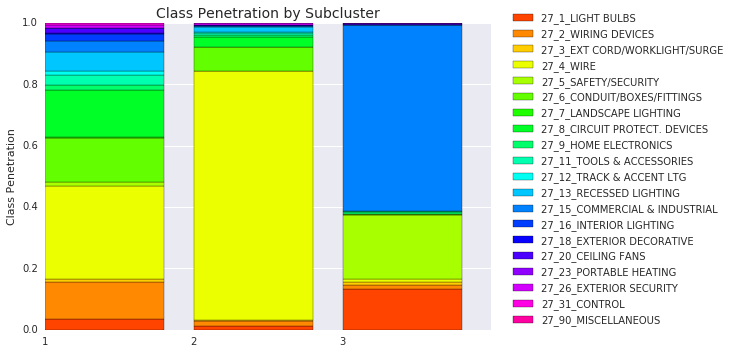

,subcluster,27_1_LIGHT BULBS,27_2_WIRING DEVICES,27_3_EXT CORD/WORKLIGHT/SURGE,27_4_WIRE,27_5_SAFETY/SECURITY,27_6_CONDUIT/BOXES/FITTINGS,27_7_LANDSCAPE LIGHTING,27_8_CIRCUIT PROTECT. DEVICES,27_9_HOME ELECTRONICS,...,27_12_TRACK & ACCENT LTG,27_13_RECESSED LIGHTING,27_15_COMMERCIAL & INDUSTRIAL,27_16_INTERIOR LIGHTING,27_18_EXTERIOR DECORATIVE,27_20_CEILING FANS,27_23_PORTABLE HEATING,27_26_EXTERIOR SECURITY,27_31_CONTROL,27_90_MISCELLANEOUS
0,1.0,0.035,0.120,0.009,0.302,0.016,0.142,0.005,0.151,0.015,...,0.013,0.063,0.034,0.022,0.004,0.015,0.000,0.011,0.006,0.0
1,2.0,0.011,0.019,0.003,0.808,0.001,0.080,0.000,0.030,0.007,...,0.002,0.017,0.004,0.000,0.001,0.001,0.001,0.004,0.001,0.0
2,3.0,0.134,0.011,0.011,0.011,0.207,0.004,0.000,0.001,0.005,...,0.000,0.001,0.607,0.000,0.001,0.001,0.004,0.000,0.001,0.0


In [26]:
# calculate the average of seed variable value for each cluster
sub_cluster_avg = subcluster.iloc[:,1:len(subcluster.columns)].groupby('subcluster').mean().reset_index()

# plot class penetration
cmap = get_cmap(len(subcluster.columns)+1)

# cumulative spending penetration
cumu = np.repeat(0, max(subcluster['subcluster']))

for i in range(1,len(subcluster.columns)-1):
  d = plt.bar(sub_cluster_avg['subcluster'], sub_cluster_avg.iloc[:,i], bottom=cumu, width=0.8, color=cmap(i), label=sub_cluster_avg.columns.values[i])
  cumu = sub_cluster_avg.iloc[:,i] + cumu

plt.ylabel('Class Penetration')
plt.title('Class Penetration by Subcluster', fontsize=14)

plt.gca().set_xlim(left=1)
plt.xticks(np.arange(min(sub_cluster_avg['subcluster']), max(sub_cluster_avg['subcluster'])+1, 1.0) )

plt.gca().set_ylim([0,1])

plt.legend(loc=(1.04,0))

plt.show()

# show average value
sub_cluster_avg.round(3)

### 4.4 Export Subcluster

Once confirmed, the subclusters will be temporily save into a BQ table. 
User then can run subclustering for another cluster if needed.
All the subclustering results will be summarized together later. 

In [27]:
# create the output dataframe 
subcluster_output = subcluster[['cust_id', 'subcluster']]

#  extract schema and create table for the first time
import datalab.bigquery as bq
subcluster_temp_table = bq.Table(output_dataset+'.cs_subcluster_temp')

if not subcluster_temp_table.exists():
  table_schema = bq.Schema.from_dataframe(subcluster_output)
  subcluster_temp_table.create(schema = table_schema, overwrite = True)

# load data
subcluster_temp_table.insert_data(subcluster_output)

# check sample data
subcluster_output.head(5)

,cust_id,subcluster
0,328245,2.0
1,961561,2.0
2,1772845,2.0
3,1777109,2.0
4,2052132,2.0


### 4.5 Repeat from 4.1
User can pick a different cluster and department from 4.1 and repeat the following steps. 

## Step 5: Export

### 5.0 Define Output Table

In [28]:
# define BigQuery table for storing clustering data
# drop the existing table
cs_cluster_output = bq.Table(output_dataset+'.cs_cluster_output')
cs_cluster_output.delete()

True

### 5.1 Build Output Data

#### 5.2.1 Pull Filter Variables

In [29]:
%%bq query -n cs_filter
select
    a.cust_id,
    a.s_trd_typ_desc,
    a.ass_chan,
    a.pro_xtra_tenure,
    coalesce(a.mgmt_tenure,'NEVER MANAGED') as mgmt_tenure,
    coalesce(a.dual_mgmt,'N') as dual_mgmt,
    coalesce(a.pasa_algnmnt,'NOT PASA-ASSIGNED') as pasa_algnmnt,
    a.par_algnmnt,
    coalesce(a.pyrmd_tier,'NO SALES') as pyrmd_tier,
    coalesce(a.top_mkt_nm,'NO SALES') as top_mkt_nm,
    case when a.top_mkt_perc > 100
         then 'N/A'
         when a.top_mkt_perc > .9 and a.top_mkt_perc <= 100
         then 'A: > 90%'
         when a.top_mkt_perc > .8 and a.top_mkt_perc <= .9
         then 'B: > 80%'
         when a.top_mkt_perc > .7 and a.top_mkt_perc <= .8
         then 'C: > 70%'
         when a.top_mkt_perc > .6 and a.top_mkt_perc <= .7
         then 'D: > 60%'
         when a.top_mkt_perc > .5 and a.top_mkt_perc <= .6
         then 'E: > 50%'
         when a.top_mkt_perc <= .5
         then 'F: <= 50%'
         end as top_mkt_rng,
    case when a.vly_perc > 100
         then 'N/A'
         when a.vly_perc > .15 and a.vly_perc <= 100
         then 'A: > 15%'
         when a.vly_perc > .05 and a.vly_perc <= .15
         then 'B: BETWEEN 5% AND 15%'
         when a.vly_perc > -.05 and a.vly_perc <= .05
         then 'C: BETWEEN -5% AND 5%'
         when a.vly_perc > -.15 and a.vly_perc <= -.05
         then 'D: BETWEEN -15% AND -5%'
         when a.vly_perc <= -.15
         then 'E: <= -15%'
         end as vly_rng,
    a.vpp_plus_bulk_discount as vpp_plus_bulk_rng,
    a.gm_rate as gm_rate_rng
  from
(
select 
    a.cust_id,
    a.s_trd_typ_desc,
    a.ass_chan,
    t.pro_xtra_tenure,
    coalesce(t.mgmt_tenure,'NEVER MANAGED') as mgmt_tenure,
    b.dual_mgmt,
    c.pasa_algnmnt,
    d.par_algnmnt,
    case when e.tot_r12_sls_amt > 100000
         then 'A: > 100K'
         when e.tot_r12_sls_amt > 35000 and e.tot_r12_sls_amt <= 100000
         then 'B: > 35K'
         when e.tot_r12_sls_amt > 0 and e.tot_r12_sls_amt <= 35000
         then 'C: > 0K'
         when coalesce(e.tot_r12_sls_amt,0) <= 0
         then 'D: <= 0K'
         end as pyrmd_tier,
    g.top_mkt_nm,
    case when h.vpp_plus_bulk_discount > .25
         then 'A: > 25%'
         when h.vpp_plus_bulk_discount > .15 and h.vpp_plus_bulk_discount <= .25
         then 'B: > 15%'
         when h.vpp_plus_bulk_discount > .05 and h.vpp_plus_bulk_discount <= .15
         then 'C: > 5%'
         when h.vpp_plus_bulk_discount >= 0 and h.vpp_plus_bulk_discount <= .05
         then 'D: >= 0%'
         when coalesce(h.vpp_plus_bulk_discount,0) < 0
         then 'E: N/A'
         end as vpp_plus_bulk_discount,
    case when h.gm_rate > .45
         then 'A: > 45%'
         when h.gm_rate > .30 and h.gm_rate <= .45
         then 'B: > 30%'
         when h.gm_rate > .15 and h.gm_rate <= .30
         then 'C: > 15%'
         when h.gm_rate > 0 and h.gm_rate <= .15
         then 'D: > 0%'
         when coalesce(h.gm_rate,0) <= 0
         then 'E: SALES BELOW COST'
         end as gm_rate,
    sum(if(coalesce(e.tot_r12_sls_amt,0) = 0,101,(g.top_mkt_sls_amt/e.tot_r12_sls_amt))) as top_mkt_perc,
    sum(if(coalesce(f.tot_ly_r12_sls_amt,0) = 0, 101,(e.tot_r12_sls_amt/f.tot_ly_r12_sls_amt)-1)) as vly_perc
  from
(
    (
    select
        a.cust_id,
        a.s_trd_typ_desc,
        'PAR' as ass_chan
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_DTL` a
          where 1 = 1
          and a.trtry_typ_cd = 1
    ) 
    union all
    (
    select
        a.cust_id,
        a.s_trd_typ_desc,
        'PASA' as ass_chan
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_DTL` a,
        unnest(pasa_dtl) b
          where 1 = 1
          and b.assg_pasa_eff_bgn_ts is not null 
          and b.assg_pasa_eff_end_ts is null 
          and (
            a.trtry_typ_cd in (2,3)
            or
            a.trtry_typ_cd is null
            )
    ) 
) a

left join
(
    select
        a.cust_id,
        'Y' as dual_mgmt
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_DTL` a,
        unnest(pasa_dtl) b
          where 1 = 1
          and b.assg_pasa_eff_bgn_ts is not null 
          and b.assg_pasa_eff_end_ts is null 
          and a.trtry_typ_cd = 1
) b
on a.cust_id = b.cust_id
left join
(
    select distinct
            a.cust_id,
            b.mkt_nm as pasa_algnmnt
          from
           `pr-customer-thd.DB2_REWARDS.CASSOC_REL` a,
           `pr-finance-thd.FINANCE_DATA.STR_HIER` b
              where 1 = 1
              and a.str_nbr = b.str_nbr
              and a.eff_end_ts is null
) c
on a.cust_id = c.cust_id
left join
(
    select
        a.cust_id,
        a.s_trd_typ_desc,
        if(a.trtry_typ_cd = 1, concat(a.div_nm,', ',a.orgn_nm),'NOT PAR-MANAGED') as par_algnmnt
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_DTL` a
          where 1 = 1
) d
on a.cust_id = d.cust_id
left join
(
    select
        a.cust_id,
        count(distinct concat(cast(a.loc_nbr as string),' ',cast(a.sltrn_dt as string),' ',cast(a.pos_rgstr_id as string),' ',cast(a.sltrn_id as string))) as tot_r12_txn_cnt,
        sum(coalesce(b.net_sls_amt,0)) as tot_r12_sls_amt
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_SLS_DTL` a,
        unnest(hdr_dtl) b,
        unnest(item_dtl) c,
        `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` d
          where 1 = 1
          and a.sltrn_dt = d.cal_dt
          and a.cust_id <> 0
          and a.cust_id is not null
          and c.dept_nbr not in (11,13,16,17,78)
          and d.fscl_prd_key_val between
            (select fscl_prd_key_val from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
                (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date)))
            and
            (select fscl_prd_key_val from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select prev_fprd_end_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))
      group by 1
) e
on a.cust_id = e.cust_id
left join
(
    select
        a.cust_id,
        sum(coalesce(b.net_sls_amt,0)) as tot_ly_r12_sls_amt
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_SLS_DTL` a,
        unnest(hdr_dtl) b,
        unnest(item_dtl) c,
        `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` d
          where 1 = 1
          and a.sltrn_dt = d.cal_dt
          and a.cust_id <> 0
          and a.cust_id is not null
          and c.dept_nbr not in (11,13,16,17,78)
          and d.fscl_prd_key_val between
            (select fscl_prd_key_val from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
                (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = 
                  (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))))
            and
            (select fscl_prd_key_val from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select prev_fprd_end_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
                (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
                  (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))))
      group by 1
) f
on a.cust_id = f.cust_id
left join
(
    select
        a.cust_id,
        a.top_mkt_nm,
        a.top_mkt_sls_amt
      from
    (
    select
        a.cust_id,
        d.mkt_nm as top_mkt_nm,
        rank() over(partition by a.cust_id order by sum(coalesce(b.net_sls_amt,0)) desc) as rank,
        sum(coalesce(b.net_sls_amt,0)) as top_mkt_sls_amt
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_SLS_DTL` a,
        unnest(hdr_dtl) b,
        unnest(item_dtl) c,
        unnest(loc_dtl) d,
        `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` e
          where 1 = 1
          and a.sltrn_dt = e.cal_dt
          and a.cust_id <> 0
          and a.cust_id is not null
          and c.dept_nbr not in (11,13,16,17,78)
          and e.fscl_prd_key_val between
            (select fscl_prd_key_val from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
                (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date)))
            and
            (select fscl_prd_key_val from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
              (select prev_fprd_end_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))
      group by 1,2
    ) a
          where 1 = 1
          and a.rank = 1
) g
on a.cust_id = g.cust_id
left join
(
select
    a.cust_id,
    case when a.tot_sls_amt = 0
      then 0
      else (a.tot_mrgn_amt)/(a.tot_sls_amt) 
      end as gm_rate,
    case when a.tot_sls_amt = 0
      then 0
      else (a.unq_comp + a.bulk)/(a.tot_sls_amt + a.bulk + a.unq_comp + 0.000001) 
      end as vpp_plus_bulk_discount
  from
(
select
    a.cust_id,
    sum(coalesce(a.tot_mrgn_amt,0)) as tot_mrgn_amt,
    sum(coalesce(a.tot_sls_amt,0)) as tot_sls_amt,
    sum(coalesce(a.unq_comp,0)) as unq_comp, -- unique competitive (vpp), buyer mkdn
    sum(coalesce(a.bulk,0)) as bulk -- bulk, buyer mkdn,
  from
(
select
    a.cust_id,
    a.txn_id,
    a.item_sku_nbr,
    sum(coalesce(a.tot_mrgn_amt,0)) as tot_mrgn_amt,
    sum(coalesce(a.tot_sls_amt,0)) as tot_sls_amt,
    sum(coalesce(b.unq_comp,0)) as unq_comp, -- unique competitive (vpp), buyer mkdn
    sum(coalesce(b.bulk,0)) as bulk -- bulk, buyer mkdn
  from
(
select
    a.cust_id,
    concat(cast(a.loc_nbr as string),' ',cast(a.sltrn_dt as string),' ',cast(a.pos_rgstr_id as string),' ',cast(a.sltrn_id as string)) as txn_id,
    b.item_sku_nbr,
    sum(coalesce(b.gross_mrgn_amt,0)) as tot_mrgn_amt, 
    sum(coalesce(b.net_sls_amt,0)) as tot_sls_amt
  from
    `pr-customer-thd.EDW_REWARDS.PRO_CUST_SLS_DTL` a,
    unnest(hdr_dtl) b,
    unnest(item_dtl) c,
    `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` d
      where 1 = 1
      and a.sltrn_dt = d.cal_dt
      and a.cust_id <> 0
      and a.cust_id is not null
      and c.dept_nbr not in (11,13,16,17,78)
      and d.cal_dt between
        (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
          (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))
        and
        (select prev_fprd_end_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date)
  group by 1,2,3
) a
left join
(
select
    concat(cast(a.loc_nbr as string),' ',cast(a.sltrn_dt as string),' ',cast(a.pos_rgstr_id as string),' ',cast(a.sltrn_id as string)) as txn_id,
    b.item_sku_nbr,
    sum(coalesce(b.rsn30_ucs_mumd_amt,0)) as unq_comp, -- unique competitive (vpp), buyer mkdn
    sum(coalesce(b.rsn49_qty_prc_mumd_amt,0))as bulk -- bulk, buyer mkdn
  from
    `pr-customer-thd.EDW_REWARDS.PRO_CUST_SLS_DTL` a,
    unnest(mumd_dtl) b, 
    `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` c
      where 1 = 1
      and a.sltrn_dt = c.cal_dt
      and c.cal_dt between
        (select fscl_prd_bgn_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt =
          (select (ly_fscl_wk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date))
        and
        (select prev_fprd_end_dt from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date)
  group by 1,2
) b
on a.txn_id = b.txn_id
and a.item_sku_nbr = b.item_sku_nbr
      where 1 = 1 
  group by 1,2,3
) a
  group by 1
) a
      where 1 = 1
) h
on a.cust_id = h.cust_id
left join
(
    select
        a.cust_id,
        a.s_trd_typ_desc,
        case when cast(round(date_diff((select (prev_fwk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date),
               a.proxtr_mbrshp_bgn_dt,day)/7) as int64) > 260
               then '+5 YEARS'
             when cast(round(date_diff((select (prev_fwk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date),
               a.proxtr_mbrshp_bgn_dt,day)/7) as int64) between 208 and 260
               then '4-5 YEARS'
             when cast(round(date_diff((select (prev_fwk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date),
               a.proxtr_mbrshp_bgn_dt,day)/7) as int64) between 156 and 208
               then '3-4 YEARS'
             when cast(round(date_diff((select (prev_fwk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date),
               a.proxtr_mbrshp_bgn_dt,day)/7) as int64) between 104 and 156
               then '2-3 YEARS'
             when cast(round(date_diff((select (prev_fwk_end_dt) from `pr-finance-thd.FINANCE_DATA.CAL_PRD_HIER` where cal_dt = current_date),
               a.proxtr_mbrshp_bgn_dt,day)/7) as int64) between 52 and 104
               then '1-2 YEARS'
             else '0-1 YEARS' 
             end as pro_xtra_tenure,
        case when a.fxd_wks_mgd_cnt >= 1 and a.fxd_wks_mgd_cnt <=52
          then '0-1 YEARS'
          when a.fxd_wks_mgd_cnt > 52 and a.fxd_wks_mgd_cnt <= 104
          then '1-2 YEARS'
          when a.fxd_wks_mgd_cnt > 104 and a.fxd_wks_mgd_cnt <= 156
          then '2-3 YEARS'
          when a.fxd_wks_mgd_cnt > 156
          then '3+ YEARS'
          end as mgmt_tenure 
      from
        `pr-customer-thd.EDW_REWARDS.PRO_CUST_DTL` a
          where 1 = 1
)  t
on a.cust_id = t.cust_id
where 1 = 1
group by 1,2,3,4,5,6,7,8,9,10,11,12
) a
where 1 = 1 
and a.cust_id in (select cust_id from USER_SXM4690.cs_id)
order by 1


In [30]:
# pull filter data into a pandas dataframe
import google.datalab.bigquery as bq
cs_filter_df = cs_filter.execute(output_options=bq.QueryOutput.dataframe()).result()

#### 5.1.2 Append Cluster / Subcluster Indices

In [31]:
# add cluster index
cs_final_output = cs_filter_df.merge(cs_cluster)

# pull subcluster data
cs_subcluster = subcluster_temp_table.to_dataframe()
cs_final_output = cs_final_output.merge(cs_subcluster, how='left')

# format dataframe
cs_final_output.columns = cs_final_output.columns.str.replace('\s+', '_')
cs_final_output.columns = cs_final_output.columns.str.replace('/', '_')

cs_final_output = cs_final_output.astype(object).where(pd.notnull(cs_final_output), None)

### 5.2 Export Final Output

In [32]:
#  extract schema and create table for the first time
import datalab.bigquery as bq
cs_cluster_output = bq.Table(output_dataset+'.cs_cluster_output')

if not cs_cluster_output.exists():
  table_schema = bq.Schema.from_dataframe(cs_final_output)
  cs_cluster_output.create(schema = table_schema, overwrite = True)

# load data
cs_cluster_output.insert_data(cs_final_output)

# check sample data
cs_final_output.head(5)

,cust_id,s_trd_typ_desc,ass_chan,pro_xtra_tenure,mgmt_tenure,dual_mgmt,pasa_algnmnt,par_algnmnt,pyrmd_tier,top_mkt_nm,...,D24_PAINT,D25_HARDWARE,D26_PLUMBING,D27_ELECTRICAL_AND_LIGHTING,D28_SEASONAL_GARDEN,D29_KITCHEN_AND_BATH,D30_MILLWORK,D59_BLINDS_AND_WALLPAPER,cluster,subcluster
0,7600,Commercial Constr.,PASA,4-5 YEARS,NEVER MANAGED,N,BIRMINGHAM,NOT PAR-MANAGED,B: > 35K,ATLANTA,...,0.11,0.134,0.07,0.047,0.046,0.031,0.182,0.008,1,None
1,8603,Property Manager,PAR,4-5 YEARS,0-1 YEARS,N,NOT PASA-ASSIGNED,"SOUTHERN, SOUTHWEST",A: > 100K,ATLANTA,...,0.096,0.067,0.383,0.02,0.045,0.102,0.089,0.004,8,None
2,54166,Other,PAR,4-5 YEARS,3+ YEARS,N,NOT PASA-ASSIGNED,"NORTHERN, NJ METRO",A: > 100K,ATLANTA,...,0.09,0.531,0.02,0.15,0.104,0.015,0.003,0,2,None
3,123808,Commercial Constr.,PASA,4-5 YEARS,NEVER MANAGED,N,ATLANTA,NOT PAR-MANAGED,C: > 0K,ATLANTA,...,0.043,0.069,0.144,0.096,0.063,0.059,0.302,0.001,1,None
4,327463,Painter,PASA,4-5 YEARS,NEVER MANAGED,N,ATLANTA,NOT PAR-MANAGED,B: > 35K,ATLANTA,...,0.486,0.06,0.036,0.066,0.117,0.035,0.032,0.006,10,None
